# Data preparation
Takes the videos, both annotated and original ones and takes each frame apart for learning on individual images.

In [1]:
!git clone https://github.com/DeepTesla/deep_learning_hf dl
%cd dl

Cloning into 'dl'...
remote: Enumerating objects: 362, done.
remote: Total 362 (delta 0), reused 0 (delta 0), pack-reused 362
Receiving objects: 100% (362/362), 684.49 MiB | 30.27 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Checking out files: 100% (47/47), done.
/content/dl


In [2]:
# import required libraries
import cv2
import os
import glob
import logging
import concurrent.futures
import numpy as np
import keras

# Set random seeds
np.random.seed(2019)
from tensorflow import set_random_seed
set_random_seed(1118)

keras.__version__

Using TensorFlow backend.


'2.2.5'

The below code iterates through all the videos in a directory and cuts them into single images. To fasten up this process multithreading was applied.

In [3]:
logging.basicConfig(level=logging.INFO, format='[%(levelname)s]: %(message)s')

train_dir = os.path.join(os.getcwd(), 'data', "train")
valid_dir = os.path.join(os.getcwd(), 'data', "validation")
test_dir = os.path.join(os.getcwd(), 'data', "test")
dirs = [train_dir, valid_dir, test_dir]

new_res = (160, 120)

def video2images(directory):
    logging.info(f"Managing directory: {directory}")

    # Get the list of available recordings
    annot_vids = sorted(glob.glob(os.path.join(directory, '*_annot_pp.avi')))
    orig_vids = sorted(glob.glob(os.path.join(directory, '*_orig_pp.avi')))

    # Check whether original and annotated recordings number match or not
    assert len(annot_vids) == len(orig_vids)
    
    logging.info(f"{directory} Number of files found: {len(annot_vids)}. Taking apart video files...")

    os.makedirs(os.path.join(directory, 'orig'))
    os.makedirs(os.path.join(directory, 'annot'))

    img_counter = 0
    vid_counter = 0
    # Iterate and postprocess every recording
    for vid_a, vid_o in zip(annot_vids, orig_vids):

        # Open recordings...
        cap_orig = cv2.VideoCapture(vid_o)
        cap_annot = cv2.VideoCapture(vid_a)
        if not cap_orig.isOpened() or not cap_annot.isOpened():
            logging.warning(f"{directory} Could not open file nr. {vid_counter}! Continuing...", )
            continue
        
        # Check whether recordings hold the same number of frames
        if cap_orig.get(cv2.CAP_PROP_FRAME_COUNT) != cap_annot.get(cv2.CAP_PROP_FRAME_COUNT):
            logging.warning(f"{directory} Different video length encountered in video nr. {vid_counter}! Continuing...")
            continue
        
        
        # Produce output videos
        logging.debug(f"{directory} Processing recording nr. {vid_counter}...")
        while cap_orig.isOpened() and cap_annot.isOpened(): # Iterate through every frame
            ret_o, frame_o = cap_orig.read()
            ret_a, frame_a = cap_annot.read()
            if not ret_o or not ret_a:
                break

            frame_o = cv2.resize(frame_o, new_res)
            frame_a = cv2.cvtColor(frame_a, cv2.COLOR_BGR2GRAY)
            frame_a = cv2.resize(frame_a, new_res)

            filename = str(img_counter).zfill(6) + '.png'
            filepath_o = os.path.join(directory, 'orig', filename)
            filepath_a = os.path.join(directory, 'annot', filename)
            # Save both frames in new file
            cv2.imwrite(filepath_o, frame_o)
            cv2.imwrite(filepath_a, frame_a)

            img_counter += 1

        
        logging.debug(f"{directory} Processing of recording nr. {vid_counter} done.")
        vid_counter += 1
        
        # Release VideoCapture resources
        cap_orig.release()
        cap_annot.release()

        os.remove(vid_a)
        os.remove(vid_o)

    logging.info(f"{directory} Video files taken apart! Images generated: {img_counter}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures_of_images = [executor.submit(video2images, directory) for directory in dirs]
    
    concurrent.futures.wait(futures_of_images)

[INFO]: Managing directory: /content/dl/data/train
[INFO]: Managing directory: /content/dl/data/validation
[INFO]: /content/dl/data/validation Number of files found: 2. Taking apart video files...
[INFO]: /content/dl/data/train Number of files found: 9. Taking apart video files...
[INFO]: Managing directory: /content/dl/data/test
[INFO]: /content/dl/data/test Number of files found: 3. Taking apart video files...
[INFO]: /content/dl/data/validation Video files taken apart! Images generated: 357
[INFO]: /content/dl/data/test Video files taken apart! Images generated: 568
[INFO]: /content/dl/data/train Video files taken apart! Images generated: 1388


Set variables for easier data access in later code.

In [4]:
train_x_dir = os.path.join(train_dir, 'orig')
train_y_dir = os.path.join(train_dir, 'annot')
valid_x_dir = os.path.join(valid_dir, 'orig')
valid_y_dir = os.path.join(valid_dir, 'annot')
test_x_dir = os.path.join(test_dir, 'orig')
test_y_dir = os.path.join(test_dir, 'annot')

train_cnt = len(glob.glob(os.path.join(train_x_dir, '*.png')))
valid_cnt = len(glob.glob(os.path.join(valid_x_dir, '*.png')))
test_cnt = len(glob.glob(os.path.join(test_x_dir, '*.png')))

assert train_cnt == len(glob.glob(os.path.join(train_y_dir, '*.png')))
assert valid_cnt == len(glob.glob(os.path.join(valid_y_dir, '*.png')))
assert test_cnt == len(glob.glob(os.path.join(test_y_dir, '*.png')))

print(f"Train set count: {train_cnt}")
print(f"Valid set count: {valid_cnt}")
print(f"Test set count: {test_cnt}")

Train set count: 1388
Valid set count: 357
Test set count: 568


# Model creation and training
We define custom generators to create batches of learning data. Then we will create our model and initialize all necessary callbacks for efficient learning. Then we fit our generators until stop conditions are satisfied.

In [0]:
def data_generator(batch_size, total_count, inputs_dir, outputs_dir):
    while True:
        # read batch size random indexed images
        t_idxs = np.random.randint(0, total_count, batch_size)
        x_shape = (batch_size, 120, 160, 3)
        y_shape = (batch_size, 120, 160)
        x = np.zeros(shape=x_shape, dtype=np.float32)
        y = np.zeros(shape=y_shape, dtype=np.float32)

        for i, idx in enumerate(t_idxs):
            filename = f'{idx:06d}.png'
            x[i] = cv2.imread(os.path.join(inputs_dir, filename))
            y[i] = cv2.imread(os.path.join(outputs_dir, filename), cv2.IMREAD_GRAYSCALE) 
        
        yield (x/255,y/255)

steps_per_epoch = 20
train_batch_size = int(train_cnt / steps_per_epoch)
valid_batch_size = int(valid_cnt / steps_per_epoch)
test_batch_size = int(test_cnt / steps_per_epoch)
train_gen = data_generator(train_batch_size, train_cnt, train_x_dir, train_y_dir)
valid_gen = data_generator(valid_batch_size, valid_cnt, valid_x_dir, valid_y_dir)
test_gen = data_generator(test_batch_size, test_cnt, test_x_dir, test_y_dir)

Our model consists of an encoder half-network that is followed by a decoder half-network, with sigmoid activation applied to the combined output of the last decoder layer.

In [6]:
kernel_size = (6,8)
filters = 64

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(120, 160, 3)))    # RGB image goes in

# ENCODER
# --------------------
for _ in range(3):
    for _ in range(2):
        model.add(keras.layers.Conv2D(filters=filters,
                                        kernel_size=kernel_size,
                                        strides=1,
                                        padding='same',
                                        use_bias=True,
                                        bias_initializer=keras.initializers.constant(value=0.0)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.ReLU())

    model.add(keras.layers.MaxPool2D(pool_size=2, strides=2))
    filters *= 2
# --------------------

# DECODER
# --------------------
for _ in range(3):
    filters = round(filters/2)
    model.add(keras.layers.UpSampling2D(size=2,
                                        interpolation='nearest'))
    for _ in range(2):
        model.add(keras.layers.Conv2D(filters=filters,
                                        kernel_size=kernel_size,
                                        strides=1,
                                        padding='same',
                                        use_bias=True,
                                        bias_initializer=keras.initializers.constant(value=0.0)))
        model.add(keras.layers.BatchNormalization())       
        model.add(keras.layers.ReLU())
# --------------------

model.add(keras.layers.Dense(units=1,
                                activation='sigmoid',
                                use_bias=True
))
model.add(keras.layers.Reshape((120,160)))

[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:216: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:223: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2239: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



In [7]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), loss="binary_crossentropy", metrics=['acc'])
model.summary()

[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3657: The name tf.log is deprecated. Please use tf.math.log instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


[WARNING]: From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 160, 64)      9280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 160, 64)      256       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 120, 160, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 160, 64)      196672    
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 160, 64)      256       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 120, 160, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 80, 64)       

As we see we have about 15M parameters and practically all of them are up for training. Now we should define our callbacks.

In [0]:
checkpoint_name = 'rightlane_segment.hdf5'
callback_checkpoint = keras.callbacks.ModelCheckpoint(filepath=checkpoint_name,
                                                          monitor='val_loss',
                                                          verbose=1,
                                                          save_weights_only=True,
                                                          save_best_only=True)

callback_early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=10, verbose=1)
callback_reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          factor=0.1,
                                                          patience=7,
                                                          verbose=1,
                                                          min_rl=1e-5)

We are ready for training! We apply our generator functions to the fit_generator function of our model.

In [9]:
model.fit_generator(
    generator=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    verbose=1,
    validation_data=valid_gen,
    validation_steps=steps_per_epoch,
    callbacks=[callback_checkpoint, callback_reduce_lr, callback_early_stopping]
)

[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



[WARNING]: From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/50
20/20 [==============================] - 40s 2s/step - loss: 0.6241 - acc: 0.6774 - val_loss: 2.3270 - val_acc: 0.7719

Epoch 00001: val_loss improved from inf to 2.32704, saving model to rightlane_segment.hdf5
Epoch 2/50
20/20 [==============================] - 26s 1s/step - loss: 0.2957 - acc: 0.8811 - val_loss: 0.7206 - val_acc: 0.7356

Epoch 00002: val_loss improved from 2.32704 to 0.72060, saving model to rightlane_segment.hdf5
Epoch 3/50
20/20 [==============================] - 26s 1s/step - loss: 0.2022 - acc: 0.9226 - val_loss: 0.6308 - val_acc: 0.7827

Epoch 00003: val_loss improved from 0.72060 to 0.63082, saving model to rightlane_segment.hdf5
Epoch 4/50
20/20 [==============================] - 26s 1s/step - loss: 0.1518 - acc: 0.9413 - val_loss: 0.3941 - val_acc: 0.8643

Epoch 00004: val_loss improved from 0.63082 to 0.39405, saving model to rightlane_segment.hdf5
Epoch 5/50
20/20 [==============================] - 26s 1s/step - loss: 0.1220 - acc: 0.9542 - val_l

It looks as our model was able to learn and since we are satisfied with the resultant metrics we will reload our last checkpoint.

In [10]:
# load best model
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Error trying to load checkpoint.
name 'path_checkpoint' is not defined


# Evaluation
We will take a couple of samples from test data and evaluate our algorithm on those unseen pictures. This will allow us to analize the generalization of our model.

In [0]:
from google.colab.patches import cv2_imshow

def predict(num):
    x, y = next(test_gen)
    x = x[:num]
    y = y[:num]
    p = [model.predict(np.expand_dims(x[i], axis=0))[0] for i in range(len(x))]
    for r in range(len(x)):
        a = np.array(x[r])*255
        b = np.zeros(shape=x[r].shape)
        c = np.zeros(shape=x[r].shape)
        for i in range(120):
            for j in range(160):
                b[i,j,0] = y[r][i,j]
                b[i,j,1] = y[r][i,j]
                b[i,j,2] = y[r][i,j]
                c[i,j,0] = p[r][i,j]
                c[i,j,1] = p[r][i,j]
                c[i,j,2] = p[r][i,j]
        b = b*255
        c = c*255
        img = np.concatenate((a, b, c), axis=1)
        cv2_imshow(img)

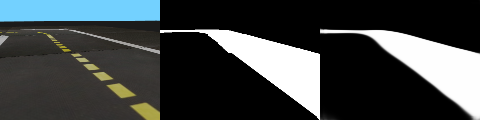

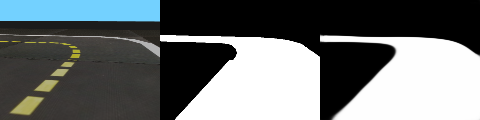

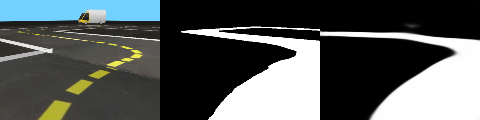

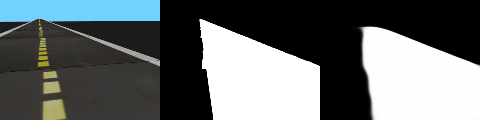

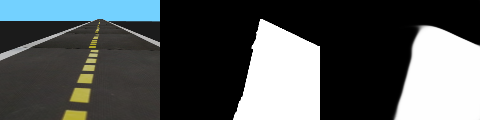

In [12]:
predict(5)

It looks as our model was able to predict quite correctly the right lane in the simulated environment. Some noises appear at some point but overall the accuracy is adequate.